# Tarea 4 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.


Esta tarea esta dividida en dos secciones. En la primera se evaluarán métodos de recomendación con métricas que no están enfocadas hacia la exactitud de las recomendaciones y la segunda sección es de utilizar Gru4Rec para generar un modelo de recomendación secuencial.

# Sección 1 - Métricas Beyond-Accuracy.

Hasta ahora, hemos visto una gran cantidad de formas de evaluar sistemas recomendadores, métricas de error, métricas de ranking, métricas de presición, etc.

Estas métricas se enfocan principalmente en evaluar si las recomendaciones entregadas se ajustan a las preferencias reales de los usuarios, ya sea prediciendo calificaciones cercanas a las dadas por el usuario o bien, recomendando elementos con los que el usuario realmente interactuó.

Sin embargo, ciertos estudios, como los llevados a cabo por Ziegler et al. (2005), Vargas y Castell (2011) y Lathia et al. (2010) proponen evaluar modelos con métricas denominadas en la literatura como métricas Beyond-Accuracy. Este tipo de métricas se enfocan en evaluar características de las recomendaciones que pueden llevar a una mayor satisfacción para el usuario o que se ajusten mejor a los objetivos de las plataformas.

En clases se mencionó dos de estas métricas: **Diversidad:** La cual mide qué tan "distintas" entre sí son las recomendaciones entregadas por el sistema y **novedad**, la cual busca que el sistema recomiende ítems que sean "novedosos", es decir, que recomiende ítems que sean poco probables que el usuario ya conozca.

Estas métricas han sido definidas de distintas maneras por distintos autores. Para el desarrollo de esta tarea, vamos a utilizar la **Diversidad de Ziegler** y la **Novedad de Vargas**.

Para esta sección, vamos a trabajar con el dataset de MovieLens.

## Descarga del dataset

In [ ]:
!pip install implicit --upgrade
!pip install deepctr-torch
!pip install tensorflow
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1

In [ ]:
!pip install wget
!pip install zipfile36
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=e935e130caf3690d8f68279ff41e998d62d63d6853b37364bdbef1586fec1aac
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

Saved under ml-100k.zip


In [ ]:
# Pueden importar las librerías que estimen necesarias.

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import implicit
import numpy as np
import seaborn as sns
import scipy.sparse as sparse
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.evaluation import auc_score, precision_at_k


In [ ]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [ ]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

df.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

### Generación de vector latente basado en contenido.

Para la métrica de Diversidad de Ziegler, necesitamos un método para calcular la distancia entre dos ítems. Para esto, usaremos la información de contenido de ítems proporcionada por MovieLens para generar vectores latentes para cada ítem. En específico, utilizaremos la información del género de las películas y el año en que fueron estrenadas.

In [ ]:
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
itemid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Primero, se obtiene el año de estreno a partir de la columna 'release_date'

In [ ]:
df_items['release_date'] = pd.to_datetime(df_items['release_date'], format='%d-%b-%Y')

# Extract year and create a new column 'year'
df_items['year'] = df_items['release_date'].dt.year

Como la escala de la información del año es mucho más elevada que la información de género, usamos una normalización de Z-score para generar la columna 'normalized_year'

In [ ]:
mean = df_items['year'].mean()
std = df_items['year'].std()

df_items['normalized_year'] = (df_items['year'] - mean) / std

In [ ]:
# Eliminamos las filas con ítems que no tienen información de año

df_items.dropna(subset=['normalized_year'], inplace=True)
df_items = df_items.reset_index()
df = df[df['itemid'].isin(df_items['itemid'])]

In [ ]:
contenido = df_items[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
                      'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western', \
                      'normalized_year']].values

In [ ]:
# Utilizamos PCA20 para generar una representación latente de dimensión 5

pca20 = PCA(n_components=5).fit_transform(contenido)

In [ ]:
# Generamos un diccionario {itemid: vector_latente}

item_feats = dict(zip(df_items['itemid'], pca20.tolist()))

In [ ]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [ ]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [ ]:
df_users.head()

,userid,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [ ]:
df_items.head()

,index,itemid,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,normalized_year
0,0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,...,0,0,0,0,0,0,0,0,1995.0,0.39386
1,1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,...,0,0,0,0,0,1,0,0,1995.0,0.39386
2,2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,0.39386
3,3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,...,0,0,0,0,0,0,0,0,1995.0,0.39386
4,4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,...,0,0,0,0,0,1,0,0,1995.0,0.39386


## Metricas

### Diversidad de Ziegler

El objetivo de la Diversidad de Ziegler es calcular la similaridad entre todos los elementos de una lista de recomendación. Mientras menor sea la similaridad total dentro de una lista, más diversa es.

In [ ]:
# Generamos un diccionario {(item1, item2): Distancia} Para evitar calcular la misma distancia más de una vez

dist_dict = dict()

def similarity(rec):
    s = 0
    for m in rec:
        s += similarity_i(m, rec)
    return s/2

def similarity_i(m, rec):
    s = 0
    if len(rec) <= 1:
        return 0
    for m2 in rec:
        if m != m2:
            s += (1 - distance(m, m2))
    return s

def distance(i1, i2):
    if (i1, i2) in dist_dict.keys():
        return dist_dict[(i1, i2)]
    dist = pairwise_distances(np.array(item_feats[i1]).reshape(1,-1), np.array(item_feats[i2]).reshape(1,-1), metric='cosine')
    dist_dict[(i1, i2)] = dist
    dist_dict[(i2, i1)] = dist
    return dist

### Novedad de Vargas

Vargas y Castell (2011) definen un concepto de novedad basado en la probabilidad de que el usuario no haya visto ese ítem anteriormente. Esta probabilidad la plantean como el logaritmo de la popularidad inversa del ítem.

In [ ]:
def popularity(iid):
    l = len(df[df['itemid'] == iid])
    return l/len(df)

dict_novelty = defaultdict(lambda: -100)
def novelty(rec):
    tot = 0
    for iid in rec:
        if dict_novelty[iid] == -100:
            novl = novelty_i(iid)
            dict_novelty[iid] = novl
            tot += novl
        else:
            tot += dict_novelty[iid]
    return tot/len(rec)

def novelty_i(iid):
    return -1*np.log2(popularity(iid))

### Metricas generales

In [ ]:
def _precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def evaluate_precision_at_k(model, n):
    mean_precision = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = [np.isin(rec, user_items_test[u], assume_unique=True).astype(int)]
        mean_precision_user = _precision_at_k(rel_vector, n)
        mean_precision += mean_precision_user

    return mean_precision / len(user_items_test)

# Se utiliza esta linea para poder usar el modulo evaluation
import implicit.evaluation

def get_AUC_at_k(model, k):

    auc = implicit.evaluation.AUC_at_k(model,
                                       user_item_matrix,
                                       user_item_matrix_test,
                                       show_progress=False,
                                       K=k
                                    )
    return auc

# Actividades

### Actividad 1: Cálculo de métricas Beyond-Accuracy.

* Elija y entrene 3 métodos vistos en clases (pueden ser cualquiera de los métodos de recomendación personalizada, ya sea de feedback implícito, explícito, híbrido, etc.)
* Elija 2 métricas de evaluación tradicional (pueden ser métricas de error, ranking, precision, etc.)
* Evalúe los métodos entrenados y genere una tabla que contenga los valores de las dos métricas elegidas por usted y las métricas de diversidad y novedad proporcionadas.
* Para las métricas Beyond-Accuracy, evalúe los sistemas con Novelty@k y Diversity@k con k = 10, 15, 20. Donde k es el largo de las listas de recomendación que se le entregan a los usuarios.

Tenga en cuenta los siguientes puntos.

* Dependiendo el método que elija, puede que tenga que realizar un pre-procesamiento distinto para los datos. Puede cambiar el dataset df utilizado por una de los splits predeterminados de MovieLens (ux.base). Si utiliza el dataset completo, recuerde generar el split train-test antes de entrenar. Si cambia el archivo, recuerde eliminar el item con el dato de fecha de estreno faltante (como se hizo al comienzo de este cuadernillo).
* Las funciones de métricas Beyond-Accuracy entregadas evalúan una única lista de recomendación. Para evaluar un sistema de recomendación, genere listas de recomendación para todos los usuarios del set de testeo y obtenga el promedio de todos los usuarios.
* Recuerde que la función entregada para la diversidad es una métrica de similaridad. Para sus análisis, debe tener en cuenta que un mayor valor implica una menor similaridad.
* Las funciones se definieron para recibir los ids de los items según están en el dataframe original (itemid). Tenga cuidado al manejar estos ids para evitar referirse a items equivocados.

Concluya a partir de los resultados de la tabla. Discuta por qué podría ser conveniente tener un nivel de Novelty y Diversity alto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [ ]:
# Preparacion Datos ALS/BPR
train_dir = "ml-100k/u3.base"
test_dir = "ml-100k/u3.test"
train_file = pd.read_csv(train_dir, sep='\t', names = ['userid', 'itemid', 'rating', 'timestamp'], header=None)
info_cols = [ 'movieid', 'title', 'release_date', 'video_release_date', 'IMDb_URL', \
              'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', \
              'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', \
              'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western' ]
#info_file = pd.read_csv('ml-100k/u.item', sep='|', index_col = 0, names = info_cols, header=None, encoding='latin-1')
# Cambio los nombres de los archivos para un formato mas familiar


df_train = train_file[train_file['itemid'].isin(df_items['itemid'])]

#df_items = info_file.copy()

# Si el rating es >= 3 entonces es relevante, si no, 0

df_train.rating = [1 if x > 3 else 0 for x in df_train.rating]

# Creo los objetos que contendran la informacion de los usuarios e items
user_items = {}
itemset = set ()

# Itero sobre toda el df de entrenamiento y junto en un diccionario el id de un usuario
# Con sus items relevantes
for row in df_train.iterrows():
    if row[1]['rating']:
        if row[1]['userid'] not in user_items:

            user_items[row[1]['userid']] = []

        user_items[row[1]['userid']].append(row[1]['itemid'])
        itemset.add(row[1]['itemid'])

# Cambio el formato del set de items para poder ordenarlo
itemset = np.sort(list(itemset))
print(itemset)

# Creo una matriz de ceros con las dimensiones UxI
sparse_matrix = np.zeros((len(user_items), len(itemset)))

# Cambio los valores de los ceros por el de 1 cuando el item es relevante
for i, items in enumerate(user_items.values()):
    sparse_matrix[i] = np.isin(itemset, items, assume_unique = True).astype(int)

# Crear una matriz comprimida que utilice menos carga computacional
user_item_matrix = sparse.csr_matrix(sparse_matrix)

# Creo un diccionario con los ids de usuarios e items

user_ids = {key: i for i, key in enumerate(user_items.keys())}
items_ids = {key: i for i, key in enumerate(itemset)}
items_ids_reverse = {i: key for i, key in enumerate(itemset)}

# Cargamos el dataset de prueba
df_test = pd.read_csv(f'{test_dir}',
                      sep='\t',
                      names=['userid', 'itemid', 'rating', 'timestamp'],
                      header=None)

df_test = df_test[df_test['itemid'].isin(df_items['itemid'])]


# rating >= 3 es relevante (1) y rating menor a 3 es no relevante (0)
df_test.rating = [1 if x >=3 else 0 for x in df_test.rating ]


user_items_test = {}
itemset_test = set()

for row in df_test.iterrows():
    if row[1]['rating'] and row[1]['userid'] in user_items:
        if row[1]['userid'] not in user_items_test:

            user_items_test[row[1]['userid']] = []

        user_items_test[row[1]['userid']].append(row[1]['itemid'])
        itemset_test.add(row[1]['itemid'])

itemset_test = np.sort(list(itemset_test))
print(itemset_test)



# Creamos la matriz csr user-item para los datos de test
sparse_matrix_test = np.zeros((len(user_items_test), len(itemset_test)))

for i, items in enumerate(user_items_test.values()):
    sparse_matrix_test[i] = np.isin(itemset_test, items, assume_unique=True).astype(int)

user_item_matrix_test = sparse.csr_matrix(sparse_matrix_test)
print(user_item_matrix_test.shape)  # Dimension de la matriz sparse del conjunto de test


<ipython-input-23-b62b9eb5080e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rating = [1 if x > 3 else 0 for x in df_train.rating]


[   1    2    3 ... 1662 1664 1674]
[   1    2    3 ... 1653 1657 1658]
(865, 1300)


In [ ]:
print(user_item_matrix.shape) # Dimension de la matriz sparse del conjunto de entrenamiento

(942, 1404)


In [ ]:
# Entrenamos los modelos ALS y BPR

# Modelo ALS
f = 15
rg = 0.01
model_als = implicit.als.AlternatingLeastSquares(factors=f, regularization=rg)
model_als.fit(user_item_matrix)

# Modelo BPR
f = 70
it = 50
model_bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f, iterations=it)
model_bpr.fit(user_item_matrix)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Como tercer modelo entrenamos light FM

dataset = Dataset()
# Se ajusta el objeto dataset con la información de usuarios e ítems

dataset.fit(users=df['userid'],
            items=df['itemid'])

# A partir de esto, podemos determinar fácilmente el número de usuarios e ítems únicos.
num_users, num_items = dataset.interactions_shape()
print(f'Num users: {num_users}, num_items: {num_items}.')
(interactions, weights) = dataset.build_interactions(df.iloc[:, 0:3].values)
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=0.25)

# Entrenamos
model_fm = LightFM(no_components=15, loss='logistic')
model_fm.fit(interactions=train_interactions, epochs=5)

Num users: 943, num_items: 1681.


In [ ]:
# Para LightFM definimos una función para obtener el top N de items recomendados, dado el score que nos arroja el modelo

df_test_w_score = df_test[df_test['itemid'].isin(df_items['itemid'])]
df_test_w_score['score'] = model_fm.predict(user_ids=df_test_w_score['userid'].values, item_ids=df_test_w_score['itemid'].values)

def get_top_n_user_recommendations_lightfm(user_id, n):
    df_score_user = df_test_w_score[df_test_w_score.userid == user_id]
    df_score_user = df_score_user.sort_values(by='score', ascending=False)
    top_n_df = df_score_user.iloc[:n]

    # Se obtienen los id de los item
    return top_n_df['itemid'].tolist()

In [ ]:
# Ahora, definimos una función que evalúe para cada usuario la novedad y diversidad para cada modelo
def evaluate_beyond_accuracy_at_k(n, model=None, metric='similarity'):
    mean = 0.
    for u in user_items_test.keys():
        if model is not None:
            rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        else:
            rec = get_top_n_user_recommendations_lightfm(u, n)

        # Como obtenemos el indice del item, lo mapeamos al id real del item
        if model is not None:
            rec = [items_ids_reverse[i] for i in rec]

        if metric == 'similarity':
            try:
                mean_user = similarity(rec)[0][0]
            except:
                mean_user = similarity(rec)
        elif metric == 'novelty':
            mean_user = novelty(rec)
        mean += mean_user

    return mean / len(user_items_test.keys())



In [ ]:
# Evaluamos cada métrica de cada modelo según diferentes k

k = 10
k_values = [10, 15, 20]
data = {
    'model_name': ['ALS', 'BPR', 'LightFM'],
}

# Evaluamos precision_at_10
als_prec = evaluate_precision_at_k(model_als, k)
bpr_prec = evaluate_precision_at_k(model_bpr, k)
fm_prec = precision_at_k(model_fm, test_interactions, train_interactions=train_interactions, k=k).mean()

# Evaluamos AUC
als_auc = get_AUC_at_k(model_als, k)
bpr_auc = get_AUC_at_k(model_bpr, k)
fm_auc = auc_score(model_fm, test_interactions, train_interactions=train_interactions).mean()

data[f'precision_at_{k}'] = [als_prec, bpr_prec, fm_prec]
data[f'AUC_score'] = [als_auc, bpr_auc, fm_auc]


for k_i in k_values:

    # Evaluamos Beyond-Accuracy
    als_diversity = evaluate_beyond_accuracy_at_k(k_i, model_als, 'similarity')
    als_novelty = evaluate_beyond_accuracy_at_k(k_i, model_als, 'novelty')

    bpr_diversity = evaluate_beyond_accuracy_at_k(k_i, model_bpr, 'similarity')
    bpr_novelty = evaluate_beyond_accuracy_at_k(k_i, model_bpr, 'novelty')

    fm_diversity = evaluate_beyond_accuracy_at_k(k_i, None, 'similarity')
    fm_novelty = evaluate_beyond_accuracy_at_k(k_i, None, 'novelty')

    data[f'diversity_at_{k_i}'] = [als_diversity, bpr_diversity, fm_diversity]
    data[f'novelty_at_{k_i}'] = [als_novelty, bpr_novelty, fm_novelty]

metrics_df = pd.DataFrame(data)
metrics_df



,model_name,precision_at_10,AUC_score,diversity_at_10,novelty_at_10,diversity_at_15,novelty_at_15,diversity_at_20,novelty_at_20
0,ALS,0.257457,0.509176,8.499701,8.411854,18.427593,8.507454,32.217633,8.586054
1,BPR,0.219538,0.508902,11.872731,8.507676,26.080209,8.616130,45.888546,8.705147
2,LightFM,0.216119,0.861865,3.171591,9.236212,6.153070,9.300127,9.068523,9.345712


### Conclusiones Basadas en los Resultados

1. **Precision@10**:
   - **ALS** tiene la mayor precisión con 0.255145, lo que indica que es el más preciso en recomendar elementos relevantes.
   - **BPR** y **LightFM** tienen puntuaciones de precisión más bajas, con 0.219538 y 0.212407 respectivamente, siendo LightFM el más bajo.

2. **AUC Score**:
   - **LightFM** tiene un puntaje AUC significativamente más alto (0.862939) comparado con ALS (0.509403) y BPR (0.508101). Esto sugiere que LightFM tiene un mejor rendimiento general en el ranking.

3. **Diversidad**:
   - **BPR** obtiene el mayor puntaje en diversidad en todos los umbrales (10, 15 y 20), lo que indica que recomienda una gama más amplia de elementos con menor similitud.
   - **ALS** tiene una diversidad moderada, menor que BPR pero mayor que LightFM.
   - **LightFM** tiene la menor diversidad, lo que sugiere que sus recomendaciones son más similares entre sí.

4. **Novedad**:
   - **LightFM** sobresale en novedad en todos los umbrales, con puntuaciones superiores a 9, lo que indica que recomienda elementos más únicos y menos populares.
   - **ALS** y **BPR** tienen puntuaciones de novedad más bajas en comparación con LightFM, con BPR ligeramente más alto que ALS.

### Compensaciones y Consideraciones

- **ALS** proporciona la mejor precisión pero a costa de una menor diversidad y una novedad moderada. Es ideal si la precisión es el objetivo principal.
- **BPR** ofrece un buen equilibrio entre diversidad y novedad con una precisión ligeramente menor. Podría ser preferido si es importante recomendar una variedad más amplia de elementos con menor similitud.
- **LightFM** se destaca por su alto AUC y novedad, pero tiene la menor precisión y diversidad. Es adecuado cuando el objetivo es recomendar elementos menos populares y más únicos


### Actividad 2: Accuracy vs. Beyond-Accuracy.

* Elija uno de los métodos que utilizó en la actividad 1 (no necesariamente tiene que ser el que entregó mejores resultados) y entrénelo modificando los valores de sus hiperparámetros.
* Elija una de las métricas tradicionales que utilizó en la actividad 1 y evalúe los modelos entrenados con distintos hiperparámetros en esta métrica en Accuracy@20 y Novelty@20.
* Genere gráficos que comparen el valor de la métrica tradicional (eje x) con las métrica beyond-accuracy (eje y). Por ejemplo, un gráfico de recall-Accuracy y otro de recall-Novelty.
* Cada gráfico debe tener al menos 5 puntos evaluados.

Concluya a partir de estos gráficos, discutiendo la forma de estos y lo que esto implica al generar un modelo recomendador.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [ ]:
# Definimos la funcion que calcula accuracy_at_k
def evaluate_accuracy_at_k(model, n):
    mean_accuracy = 0.
    for u in user_items_test.keys():
        rec = model.recommend(user_ids[u], user_item_matrix[user_ids[u]], n)[0]
        rec = [itemset[r] for r in rec]
        rel_vector = np.isin(itemset, user_items_test[1], assume_unique=True).astype(int)
        true = np.isin(itemset, rec, assume_unique=True).astype(int)
        mean_accuracy_user = np.mean(rel_vector == true)
        mean_accuracy += mean_accuracy_user
    return mean_accuracy / len(user_items_test)


In [ ]:
# Elegimos el modelo ALS

# Probamos el modelo con diferentes hiperparámetros
hyp_params = [
       (10, 0.01),
        (10, 0.02),
        (10, 0.05),

        (10, 0.07),
        (15, 0.01),
        (15, 0.02),
         (15, 0.05),
          (15, 0.07),
          (20, 0.01),
          (20, 0.02),
          (20, 0.05),
          (20, 0.07),
          ]


models = []
prec_at_20_data = []
novelty_at_20_data = []
accuracy_at_20_data = []

for f, rg in hyp_params:
    print('Training model with', f, 'latent factors and ', rg, 'reg. factor')
    model_als = implicit.als.AlternatingLeastSquares(factors=f, regularization=rg)
    model_als.fit(user_item_matrix, show_progress=False)

    # Utilizamos la metrica precision_at_20 para evaluar
    als_prec = evaluate_precision_at_k(model_als, 20)

    # Evaluamos novelty_at_20
    als_novelty = evaluate_beyond_accuracy_at_k(20, model_als, 'novelty')

    # Evaluamos accuracy_at_20
    als_accuracy = evaluate_accuracy_at_k(model_als, 20)

    models.append(model_als)
    prec_at_20_data.append(als_prec)
    novelty_at_20_data.append(als_novelty)
    accuracy_at_20_data.append(als_accuracy)



Training model with 10 latent factors and  0.01 reg. factor
Training model with 10 latent factors and  0.02 reg. factor
Training model with 10 latent factors and  0.05 reg. factor
Training model with 10 latent factors and  0.07 reg. factor
Training model with 15 latent factors and  0.01 reg. factor
Training model with 15 latent factors and  0.02 reg. factor
Training model with 15 latent factors and  0.05 reg. factor
Training model with 15 latent factors and  0.07 reg. factor
Training model with 20 latent factors and  0.01 reg. factor
Training model with 20 latent factors and  0.02 reg. factor
Training model with 20 latent factors and  0.05 reg. factor
Training model with 20 latent factors and  0.07 reg. factor


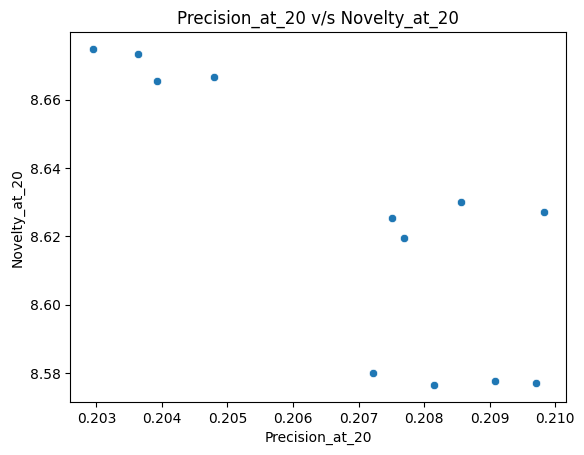

In [ ]:
# Graficamos precision vs novelty at 20
ax = sns.scatterplot(x=prec_at_20_data, y=novelty_at_20_data)
plt.title('Precision_at_20 v/s Novelty_at_20')
plt.xlabel('Precision_at_20')
plt.ylabel('Novelty_at_20')
plt.show()

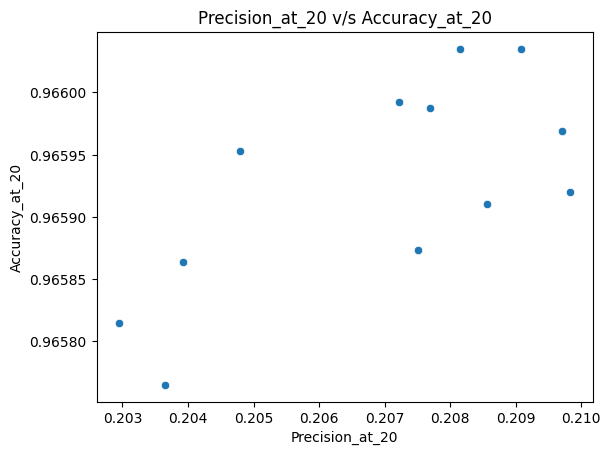

In [ ]:
# Graficamos precision vs accuracy at 20
ax = sns.scatterplot(x=prec_at_20_data, y=accuracy_at_20_data)
plt.title('Precision_at_20 v/s Accuracy_at_20')
plt.xlabel('Precision_at_20')
plt.ylabel('Accuracy_at_20')
plt.show()

### Apreciaciones
* La precisión es relativamente estable en los diferentes hiperparámetros, pero muestra una ligera disminución a medida que los factores aumentan de 10 a 20 y la regularización aumenta a 0.07.  
* La novedad generalmente aumenta con el número de factores y valores de regularización más altos  
* La exactitud se mantiene muy alta y estable en todas las configuraciones de hiperparámetros, con los valores más altos cerca de 0.966.

### Concluciones   
* La mayor novedad se logra con factores más altos y valores de regularización más altos, pero a un pequeño costo en precisión.
* La exactitud es muy estable en todas las configuraciones de hiperparámetros, lo que sugiere que el modelo ALS mantiene un nivel constante de predicciones correctas independientemente de la configuración específica de factores y regularización.

### Actividad 3: Beyond-Accuracy vs. Beyond-Accuracy

Repita el procedimiento de la actividad 2, pero esta vez genere un gráfico de Novelty@20 Vs. Diversity@20.

A partir de este gráfico, concluya la correlación entre estas dos métricas y explique en sus palabras por qué cree que se da este efecto.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [ ]:
# Repetimos todo lo anterior, pero utilizando sumando la métrica diversity_at_20

diversity_at_20_data = []

for i in range(len(models)):

    # Evaluamos diversity_at_20
    als_diversity = evaluate_beyond_accuracy_at_k(20, models[i], 'similarity')
    diversity_at_20_data.append(als_diversity)

diversity_at_20_data


[31.91511018746589,
 32.912130932767596,
 32.36911377632107,
 32.35084771610213,
 29.650321393975233,
 30.108173110692153,
 30.666168417789137,
 30.91026626797397,
 28.6803804275554,
 28.623756207035427,
 29.658731635425802,
 28.909054644188817]

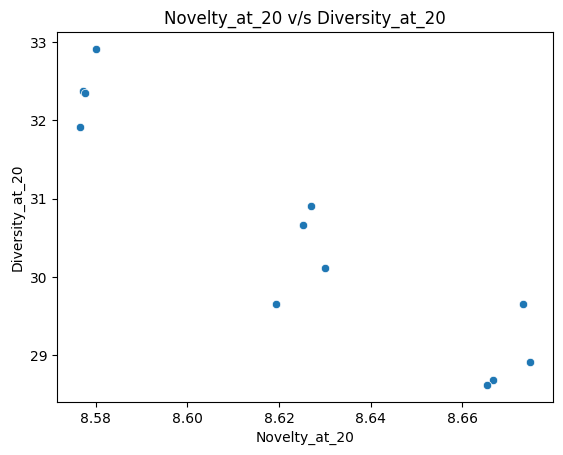

In [ ]:
# Graficamos novelty vs diversity at 20
ax = sns.scatterplot(x=novelty_at_20_data, y=diversity_at_20_data)
plt.title('Novelty_at_20 v/s Diversity_at_20')
plt.xlabel('Novelty_at_20')
plt.ylabel('Diversity_at_20')
plt.show()

 * En el gráfico, parece haber una correlación negativa entre diversidad y novedad. Es decir, a medida que la diversidad aumenta (menor similitud entre recomendaciones), la novedad también tiende a aumentar (más recomendaciones únicas o raras).

 *  Aunque la correlación negativa sugiere que a medida que una métrica aumenta, la otra tiende a disminuir, es crucial encontrar un equilibrio entre diversidad y novedad para proporcionar recomendaciones útiles y relevantes para los usuarios. Un modelo que ofrece una diversidad demasiado alta puede generar recomendaciones irrelevantes, mientras que uno que prioriza demasiado la novedad puede perder de vista las preferencias individuales del usuario.

# Sección 2 - Recomendación secuencial.

En esta sección utilizaremos Gru4Rec, para entrenar un modelo de recomendación secuencial basado en sesiones.

## Entrenamiento de Gru4Rec

Seguiremos el mismo procedimiento utilizado en el tutorial de Gru4Rec para entrenar el modelo. Este proceso puede llegar a tomar más de 40 minutos, pero solo se debe realizar una vez, ya que los archivos generados se guardan en la carpeta en la que se está corriendo el cuadernillo, por lo que se recomienda ejecutar el código con anticipación.

In [ ]:
!pip install py7zr
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 678.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 63.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.9 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+

In [ ]:
!git clone https://github.com/hidasib/GRU4Rec_PyTorch_Official --single-branch src

fatal: destination path 'src' already exists and is not an empty directory.


In [ ]:
# Descarga del dataset. Esto puede tomar hasta ~40 minutos, pero solo se debe realizar una vez

!curl https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z --output data.7z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  273M  100  273M    0     0  17.8M      0  0:00:15  0:00:15 --:--:-- 20.2M


In [ ]:
from py7zr import unpack_7zarchive
import shutil

shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('data.7z', './rsc15')

**Impotante:** Es posible que al ejecutar el código, se encuentren con el error '*IndexError: tensors used as indices must be long, byte or bool tensors*'. Para arreglar este error, deben modificar la línea 23 del archivo evaluation.py por:

tscores = torch.diag(oscores[out_idxs.long()])

En el tutorial Gru4Rec podrán encontrar una explicación paso a paso.

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
src_path = './rsc15/'
dst_path   = './data/'

In [ ]:
def process(src_path, dst_path):
    data = pd.read_csv(src_path + 'yoochoose-clicks.dat', sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
    data.columns = ['SessionId', 'TimeStr', 'ItemId']

    # Convertimos el Timestamp en un objeto datetime
    data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
    del(data['TimeStr'])

    # Tomamos las sesiones de largo > 1
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]

    # Filtramos los items que aparecen menos de 5 veces.
    item_supports = data.groupby('ItemId').size()
    data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]

    # Volvemos a filtrar las sesiones de largo 1
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

    # Vamos a definir el set de testeo como todas las interacciones ocurridas el último día.
    tmax = data.Time.max()
    session_max_times = data.groupby('SessionId').Time.max()

    session_train = session_max_times[session_max_times < tmax-86400].index
    train = data[np.in1d(data.SessionId, session_train)]

    session_test = session_max_times[session_max_times >= tmax-86400].index
    test = data[np.in1d(data.SessionId, session_test)]
    test = test[np.in1d(test.ItemId, train.ItemId)]
    tslength = test.groupby('SessionId').size()
    test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
    print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
    test.to_csv(dst_path + 'test.tsv', sep='\t', index=False)

    # Validation: Vamos a usar el penúltimo día para el set de validación
    tmax = train.Time.max()
    session_max_times = train.groupby('SessionId').Time.max()
    session_train = session_max_times[session_max_times < tmax-86400].index
    session_valid = session_max_times[session_max_times >= tmax-86400].index

    train_tr = train[np.in1d(train.SessionId, session_train)]
    valid = train[np.in1d(train.SessionId, session_valid)]
    valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)]
    tslength = valid.groupby('SessionId').size()
    valid = valid[np.in1d(valid.SessionId, tslength[tslength>=2].index)]
    print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))
    valid.to_csv(dst_path + 'validation.tsv', sep='\t', index=False)


    print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
    train_tr.to_csv(dst_path + 'train.tsv', sep='\t', index=False)

In [ ]:
process(src_path, dst_path)  # Toma ~ 10 minutos

Test set
	Events: 71222
	Sessions: 15324
	Items: 6751
Validation set
	Events: 58233
	Sessions: 12372
	Items: 6359
Train set
	Events: 31579006
	Sessions: 7953885
	Items: 37483


In [ ]:
def train_fraction(df, fraction, prefix="train", path="./data/"):

    length = len(df['ItemId'])
    first_session = df.iloc[length - length//fraction].SessionId # Se toma el Id de la sesión que está en la fracción deseada
    df = df.loc[df['SessionId'] >= first_session] # Se guardan únicamente las sesiones cuyo Id sea mayor al Id encontrado

    # Nota: Este procedimiento sólo funciona correctamente si el dataset está ordenado según SessionId

    itemids = df['ItemId'].unique()
    n_items = len(itemids)

    print('Fractioned data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(df), df.SessionId.nunique(), df.ItemId.nunique()))
    filename = path + '{}_{}.tsv'.format(prefix, fraction)
    df.to_csv(filename, sep='\t', index=False)
    print("Saved as {}".format(filename))

In [ ]:
# Para el propósito de esta demo, utilizamos una fracción del dataset de entrenamiento.
fraction = 64
train = pd.read_csv(dst_path + 'train.tsv', sep='\t', dtype={'ItemId':np.int64})
train_fraction(train, fraction)
train_frac = pd.read_csv(dst_path + 'train_64.tsv', sep='\t', dtype={'ItemId':np.int64})

Fractioned data set
	Events: 71391
	Sessions: 17450
	Items: 8724
Saved as ./data/train_64.tsv


In [ ]:
!python src/run.py ./data/train_64.tsv -t ./data/test.tsv -m 1 5 10 20 -ps layers=100,batch_size=32,dropout_p_embed=0.1,dropout_p_hidden=0,learning_rate=0.1,momentum=0,n_sample=2048,sample_alpha=0.75,bpreg=0,logq=1,loss=cross-entropy,constrained_embedding=True,elu_param=0,n_epochs=200 -d cuda:0

Creating GRU4Rec model on device "cuda:0"
SET   layers                  TO   [100]           (type: <class 'list'>)
SET   batch_size              TO   32              (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1             (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0             (type: <class 'float'>)
SET   learning_rate           TO   0.1             (type: <class 'float'>)
SET   momentum                TO   0.0             (type: <class 'float'>)
SET   n_sample                TO   2048            (type: <class 'int'>)
SET   sample_alpha            TO   0.75            (type: <class 'float'>)
SET   bpreg                   TO   0.0             (type: <class 'float'>)
SET   logq                    TO   1.0             (type: <class 'float'>)
SET   loss                    TO   cross-entropy   (type: <class 'str'>)
SET   constrained_embedding   TO   True            (type: <class 'bool'>)
SET   elu_param               TO   0.0             (type: <class '

### Actividad 4: Recomendación en base a sesiones.

Reporte los resultados del entrenamiento, los valores de Recall y MRR obtenidos.
Explique, en sus palabras, el desafío de recomendación en base a sesiones. Cómo difiere de los desafíos que hemos visto hasta ahora, y cómo se evalúa.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

## Resultados

Luego de 200 épocas, deberías obtener un desempeño similar al siguiente:

	 - Recall@20: 0.534552
	 - MRR@20   : 0.208995

El desafío de crear sistemas recomendadores en base a sesiones se basa principalmente en que son problemas donde no sabemos a ciencia cierta cómo individualizar un usuario que interactúa con un ítem, ni tampoco entendemos de forma determinística las preferencias del usuario, sino que el paradigma es más basado en sesiones e interacciones, típicamente implícitas.

En tales casos, como lo puede ser navegar por un ecommerce sin haber iniciado sesión, podemos tener mucho ruido en los datos, teniendo una gran cantidad de interacciones implícitas que podrían ser difíciles de interpretar, dado que los usuarios podrían interactuar con muchísimos ítems y extender ampliamente una sesión. Para lo anterior, a diferencia de los sistemas recomendadores tradicionales, por ejemplo de filtrado colaborativo, no sabemos si realmente el usuario está interesado en todos los ítems con los que interactuó, por lo que el primer desafío se torna en realizar una limpieza de datos efectiva, basado en el largo de las sesiones o en el largo del tiempo en que el usuario estuvo detenido en un ítem `dwell time`, el cual se debe identificar las interacciones que no son relevantes.

Por otra parte, no tenemos en el caso de los sistemas recomendadores basados en sesiones no tenemos información del usuario en cuestión, por lo que no podríamos complementar la recomendación con información de preferencias anteriores de este ni información contextual. Con lo anterior, solo podemos aprender patrones acerca de las sesiones e interacciones de ítems que estén inmersos en esta. Por el contrario, en métodos de filtrado colaborativo o basados en contenido sí podemos utilizar información del usuario y contextual para enriquecer las recomendaciones.

En último lugar, no tenemos un orden claro de las sesiones, ya que podrían ser recurrentes, por lo que se requiere tratar cada sesión como un dato atemporal y que dentro de cada sesión se incluya la temporalidad de las interacciones, con lo cual no podemos inferir patrones con redes recurrentes de forma tan simple.

Para la evaluación de estos sistemas, como se tiene información típicamente implícita, conviene tratarlos como un problema de clasificación, en donde se evalúa la calidad de la lista de recomendación entregada según un largo `k`. Esto, ya que el usuario (anónimo) probablemente no entrega un ráting de un producto (generalmente se pide un login para lo anterior), sino que solo interactua con el anterior, teniendo señales binarias de la preferencia en los productos. Si bien acá hablamos de usuarios, en realidad el sistema solo evalúa sesiones.


### Actividad 5: Análisis de relevancia de secuencia.

Gru4Rec, al ser un recomendador secuencial, utiliza la información de la secuencia de interacciones del usuario para predecir el siguiente elemento. En este ejercicio veremos si el orden en que el usuario interactuó con los ítems realmente influye en el rendimiento de Gru4Rec.

Para testear esto, vamos a modificar la base de datos, cambiando el orden en que los usuarios interactuaron con los items en el set de entrenamiento. Para lograr esto, usted simplemente debe:

* Modificar la columna 'Time' del dataframe 'train_frac' con tal de que el orden en que los usuarios interactuaron con los items sea distinto al original. Esto lo puede lograr de distintas formas; asignándole un valor aleatorio a la columna Time, invirtiéndo los valores de Time en el dataframe, etc.
* Importante: Solo modifique el orden en que los usuarios interactuaron con los ítems. No debe agregar, eliminar ni intercambiar los ítems que fueron vistos por cada usuario. Cada usuario debe haber interactuado con exactamente los mismos items con los que interactuó originalmente, pero en un orden diferente.
* Guarde el dataframe en un archivo .tsv.
* Entrene el modelo Gru4Rec sobre su nuevo dataset. Todos los hiperparámetros deben ser los mismos que en el entrenamiento original, para que este sea el único cambio.

Explique su estrategia de modificación del dataset y reporte los resultados, tanto de recall como de MRR y compárelos con los resultados del dataset original. Convluya a partir de esto la importancia del orden de las interacciones en Gru4Rec.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [ ]:
# Ruta a la carpeta
dst_path   = './data/'

# Se lee el archivo tsv
train_frac = pd.read_csv(dst_path + 'train_64.tsv', sep='\t', dtype={'ItemId':np.int64})

# Se calculan los tiempos maximos y minimo para de ahí tener los rangos para el valor aleatorio
min_time = train_frac['Time'].min()
max_time = train_frac['Time'].max()

# Se calculan los ragos aleatorios
train_frac_nt = train_frac.copy()
train_frac_nt['Time'] = np.random.uniform(min_time, max_time, size=len(train_frac_nt))

# Se guarda en un nuevo archo tsv
df.to_csv(dst_path + 'train_64_rand_time.tsv', sep="\t")

In [ ]:
!python src/run.py ./data/train_64_rand_time.tsv -t ./data/test.tsv -m 1 5 10 20 -ps layers=100,batch_size=32,dropout_p_embed=0.1,dropout_p_hidden=0,learning_rate=0.1,momentum=0,n_sample=2048,sample_alpha=0.75,bpreg=0,logq=1,loss=cross-entropy,constrained_embedding=True,elu_param=0,n_epochs=200 -d cuda:0

Creating GRU4Rec model on device "cuda:0"
SET   layers                  TO   [100]           (type: <class 'list'>)
SET   batch_size              TO   32              (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1             (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0             (type: <class 'float'>)
SET   learning_rate           TO   0.1             (type: <class 'float'>)
SET   momentum                TO   0.0             (type: <class 'float'>)
SET   n_sample                TO   2048            (type: <class 'int'>)
SET   sample_alpha            TO   0.75            (type: <class 'float'>)
SET   bpreg                   TO   0.0             (type: <class 'float'>)
SET   logq                    TO   1.0             (type: <class 'float'>)
SET   loss                    TO   cross-entropy   (type: <class 'str'>)
SET   constrained_embedding   TO   True            (type: <class 'bool'>)
SET   elu_param               TO   0.0             (type: <class '

## Resultados

Luego de 200 épocas, deberías obtener un desempeño similar al siguiente:

	 - Recall@20: 0.537514
	 - MRR@20   : 0.209664

Sobre la estrategia de modificación del dataset, lo que se hizo fue calcular el valor máximo y mínimo de la columna `Time`, para luego reimplementar la columna en base a valores aleatorios de distribución uniforme. Con eso aseguramos aleatoriedad pero con valores que estén dentro de los rangos que manteníamos de `Time` en el dataset original.

Con respecto a los valores de `Recall` y `MRR` los valores tienden a ser similares a cuando usamos el dataset de entrenamiento original. Lo anterior nos puede dar luces de que en este problema en particular realidad **no tiene mucha importancia el orden de las interacciones** con ítems que el usuario haya tenido en una sesión, dado que la red probablemente solo considera los eventos de interacciones para la sesión, sin considerar el tiempo entre diferentes interacciones, lo cual no estamos capturando en este caso. Este podría ser el caso de un usuario que está indeciso navegando en una página de retail y que no sabría bien qué compras realizar, por ejemplo.

Diferente es el caso en que podríamos considerar el `dwell time` de un ítem, el cual es el tiempo que el usuario permaneció viendo el ítem. Este dato obviamente cambia si cambiamos la distribución de la columna `Time` y, asimismo, cambiaría el interés que cada usuario tiene en cada ítem. En tal caso, los resultados que arrojaría la red cambiarían por cada sesión ya que las preferencias de los usuarios por los ítems serían diferentes.